# Creating Datasets

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *

In [3]:
base_path = Path('/home/rahul/datasets/Synopsis_Model_All_Concepts/')

In [4]:
def get_label_dirs(path, diagnostic=True):
    label_dirs = [f for f in os.listdir(path) if f.startswith(f'{path.name}_')]
    label_dirs.sort()
    if diagnostic:
        num = [len((Path(path/label_dir)).ls()) for label_dir in label_dirs]
        file_count = pd.DataFrame({
            'LABEL': label_dirs,
            'NUM_FILES': num
        })
        print(file_count.to_string(index=False))
        print()
        print(f"===== TOTAL NO. OF FILES = {file_count['NUM_FILES'].sum()} =====")

    return label_dirs

In [5]:
category = 'shot_lighting'

path = base_path/category
label_dirs = get_label_dirs(path)

                    LABEL  NUM_FILES
       shot_lighting_hard        623
   shot_lighting_key_high        318
    shot_lighting_key_low        792
    shot_lighting_neutral        271
 shot_lighting_silhouette        332
       shot_lighting_soft        427

===== TOTAL NO. OF FILES = 2763 =====


For `label`s that have < 350 images, take 50 into the validation set, and put the rest into the training set

In [6]:
train_fnames, valid_fnames = {}, {}

for label in label_dirs:
    files    = get_files(path/label, presort=True)
    np.random.seed(42)
    np.random.shuffle(files)
    if len(files) < 350:
        valid_fnames[label] = files[:50]
        train_fnames[label] = files[50:]
    else:
        valid_fnames[label] = files[:100]
        train_fnames[label] = files[100:]
        
fnames_train = sum(train_fnames.values(),[])
fnames_valid = sum(valid_fnames.values(),[])

In [7]:
len(fnames_train)
len(fnames_valid)

2310

450

Add NAs from `textures`

In [8]:
textures_dir = base_path/'texture'
textures_subdirs = get_label_dirs(textures_dir)

                LABEL  NUM_FILES
       texture_banded        120
      texture_blotchy        120
      texture_braided        120
       texture_bubbly        120
        texture_bumpy        120
    texture_chequered        120
    texture_cobwebbed        120
      texture_cracked        120
 texture_crosshatched        120
  texture_crystalline        120
       texture_dotted        240
      texture_fibrous        120
      texture_flecked        120
       texture_frilly        120
        texture_gauzy        120
         texture_grid        120
      texture_grooved        120
  texture_honeycombed        120
   texture_interlaced        120
      texture_knitted        120
     texture_lacelike        120
        texture_lined        120
      texture_marbled        120
       texture_matted        120
       texture_meshed        120
      texture_paisley        120
   texture_perforated        120
       texture_pitted        120
      texture_pleated        120
       tex

5520 is way too many files for the number of samples we have in lighting. <br>
So, we take 10 from each `texture` label in the validation set, and 30 for the training set

In [9]:
textures_train_fnames, textures_valid_fnames = {}, {}

for label in textures_subdirs:
    files    = get_files(textures_dir/label, presort=True)
    np.random.seed(42)
    np.random.shuffle(files)
    
    # grab 30 train, 10 valid images from each label
    textures_valid_fnames[label] = files[:10]
    textures_train_fnames[label] = files[10:40]

In [10]:
fnames_textures_train = sum(textures_train_fnames.values(),[])
fnames_textures_valid = sum(textures_valid_fnames.values(),[])

print(f'No. of training   samples from `textures` --> {len(fnames_textures_train)}')
print(f'No. of validation samples from `textures` --> {len(fnames_textures_valid)}')

No. of training   samples from `textures` --> 1350
No. of validation samples from `textures` --> 450


In [11]:
fnames_valid = fnames_valid + fnames_textures_valid
fnames_train = fnames_train + fnames_textures_train

In [12]:
shuffle_df = lambda df: df.reindex(np.random.permutation(df.index)).reset_index(drop=True)

def get_data_df(fnames:list, regex:str, na_label:str) -> pd.DataFrame:
    row_list = []
    for i,f in enumerate(fnames):
        rowdict = {}
        rowdict['filepath'] = str(f)
        label = re.search(regex, str(f))
        if label:
            label = label.group(0).split('/')[:-1][0] # remove '/'; get str, not list
            rowdict['label'] = label
        else:
            rowdict['label'] = na_label
        #rowdict['filepath'] = re.search('(?<=shot_location/).*', str(f)).group(0)
        row_list.append(rowdict)

    df = pd.DataFrame(row_list)
    return shuffle_df(df)

In [14]:
df_valid.head(5)

filepath                  label
0  /home/rahul/datasets/Synopsis_Model_All_Concep...  shot_lighting_neutral
1  /home/rahul/datasets/Synopsis_Model_All_Concep...     shot_lighting_hard
2  /home/rahul/datasets/Synopsis_Model_All_Concep...                     NA
3  /home/rahul/datasets/Synopsis_Model_All_Concep...                     NA
4  /home/rahul/datasets/Synopsis_Model_All_Concep...                     NA

In [15]:
img_size   = (224,224)
batch_size = 64

tfms = get_transforms()
tfms = tfms[0], []      # remove cropping tfm from validation-transforms

# remove Lighting transforms since we're trying to model lighting...
train_tfms = [t for t in get_transforms()[0] if not isinstance(t.tfm, TfmLighting)]
tfms = train_tfms, []

In [16]:
datagrab_lighting = partial(get_data_df, regex='(?<=shot_lighting/).*/', na_label = 'NA')
df_train = datagrab_lighting(fnames_train)
df_valid = datagrab_lighting(fnames_valid)

lls = LabelLists(path  = '/',
                 train = ImageList.from_df(df_train, path='/'),
                 valid = ImageList.from_df(df_valid, path='/'))

data_lighting_single = (lls
                        .label_from_df()
                        .transform(tfms=tfms,
                                   size=img_size,
                                   resize_method=ResizeMethod.SQUISH)
                        .databunch(bs=batch_size)
                        .normalize(imagenet_stats))

data_lighting_single.c
data_lighting_single.classes

7

['NA',
 'shot_lighting_hard',
 'shot_lighting_key_high',
 'shot_lighting_key_low',
 'shot_lighting_neutral',
 'shot_lighting_silhouette',
 'shot_lighting_soft']

In [33]:
data_lighting_single.train_ds

LabelList (3660 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shot_lighting_soft,NA,NA,shot_lighting_key_high,shot_lighting_key_low
Path: /

In [34]:
data_lighting_single.valid_ds

LabelList (900 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shot_lighting_key_high,NA,NA,shot_lighting_key_high,NA
Path: /

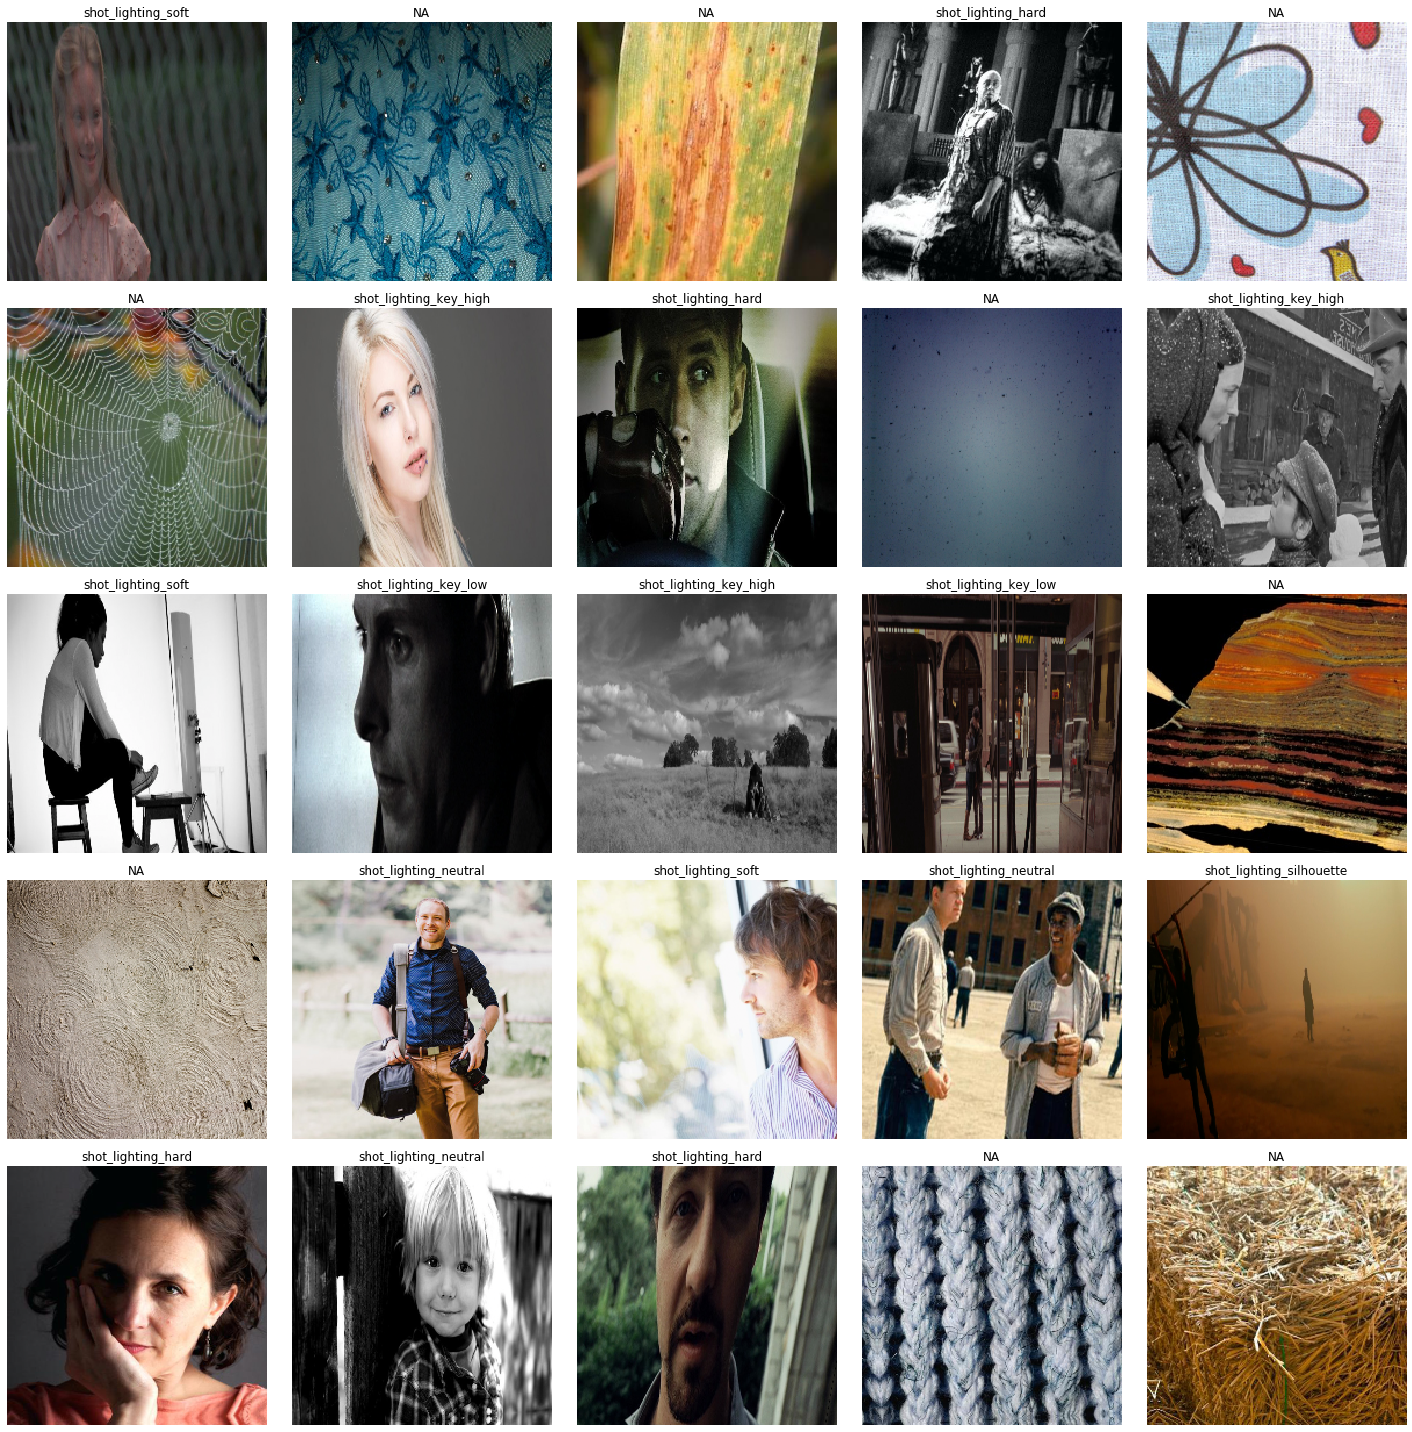

In [28]:
data_lighting_single.show_batch()

In [17]:
datagrab_lighting = partial(get_data_df, regex='(?<=shot_lighting/shot_lighting_).*/', na_label = 'NA')
df_train = datagrab_lighting(fnames_train)
df_valid = datagrab_lighting(fnames_valid)

lls = LabelLists(path  = '/',
                 train = ImageList.from_df(df_train, path='/'),
                 valid = ImageList.from_df(df_valid, path='/'))

data_lighting_multi = (lls
                      .label_from_df(label_delim = '_')
                      .transform(tfms=tfms,
                                 size=img_size,
                                 resize_method=ResizeMethod.SQUISH)
                      .databunch(bs=batch_size)
                      .normalize(imagenet_stats))

data_lighting_multi.c
data_lighting_multi.classes

8

['NA', 'hard', 'high', 'key', 'low', 'neutral', 'silhouette', 'soft']

In [36]:
data_lighting_multi.train_ds

LabelList (3660 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
NA,NA,NA,hard,NA
Path: /

In [37]:
data_lighting_multi.valid_ds

LabelList (900 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
NA,NA,NA,NA,NA
Path: /

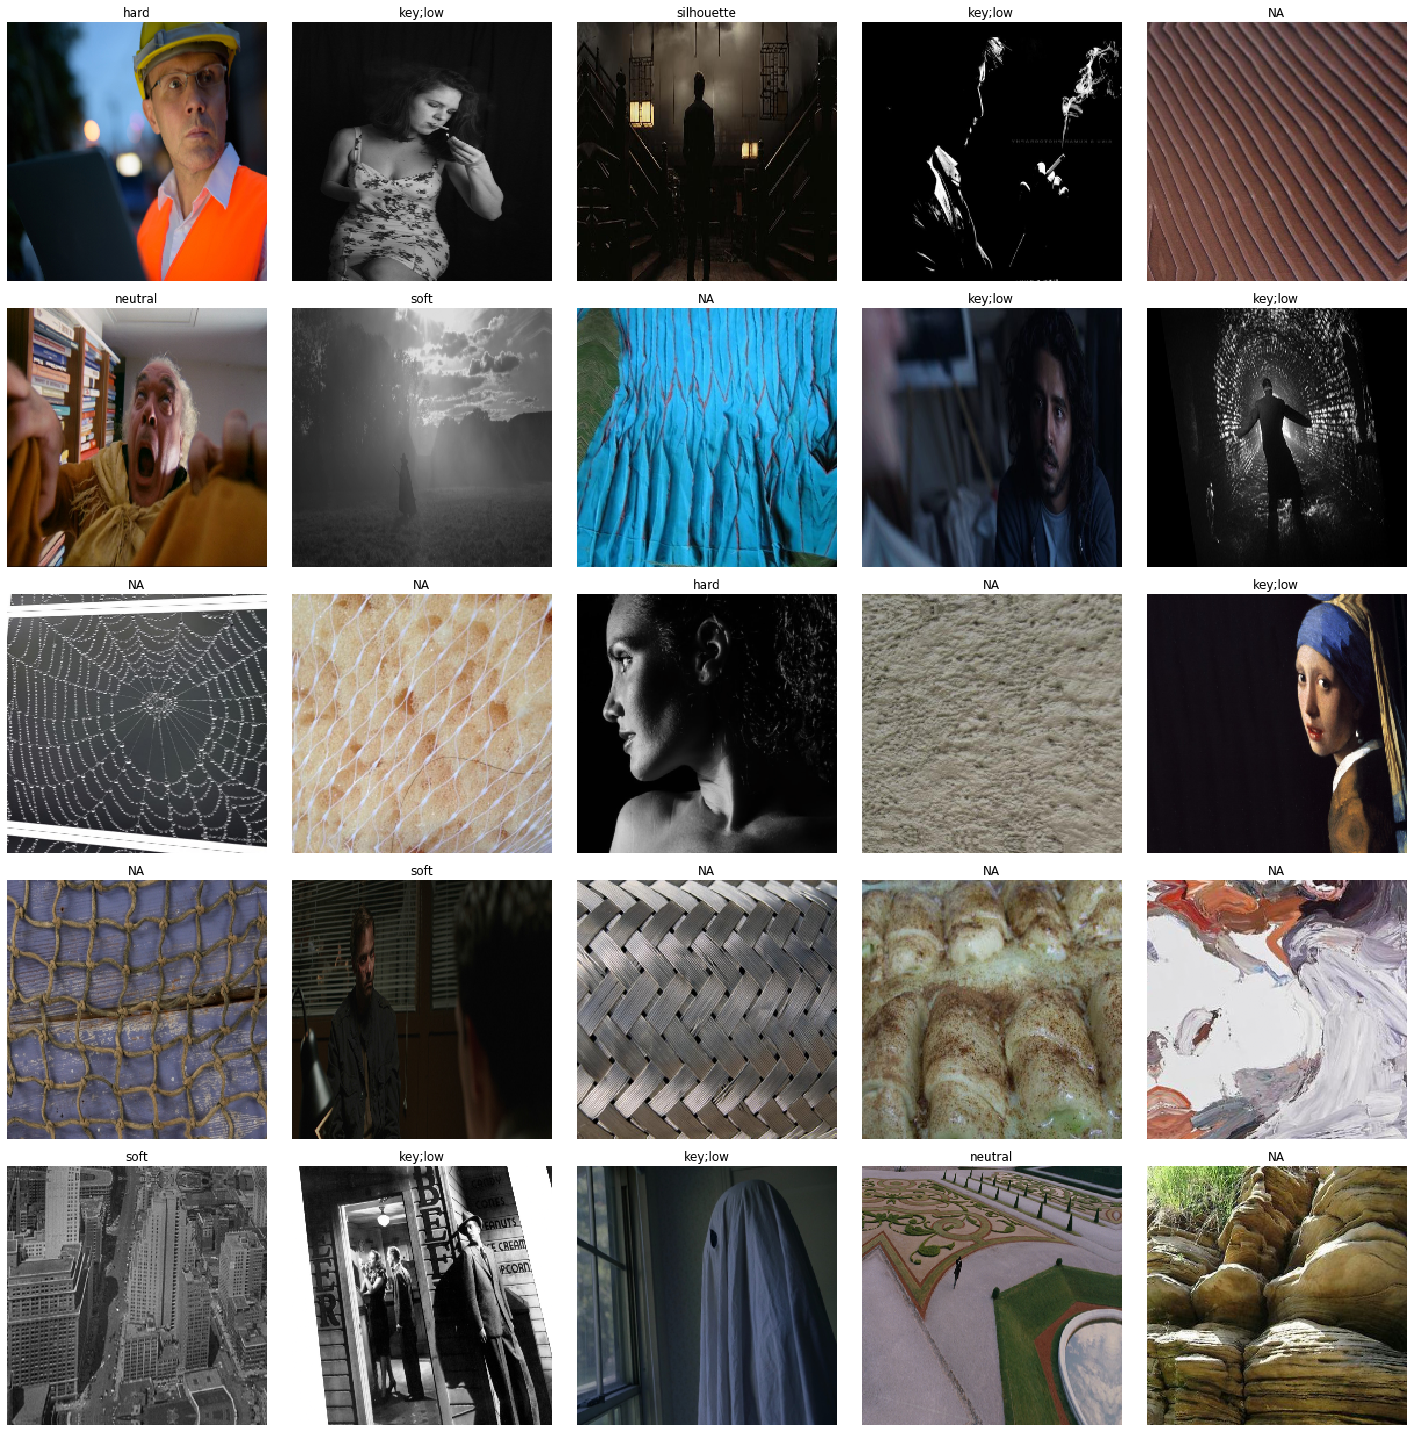

In [29]:
data_lighting_multi.show_batch()

In [19]:
acc_02  = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

metrics_multi = [acc_02, f_score]

In [20]:
learn_multi = cnn_learner(data_lighting_multi, models.mobilenet_v2,
                          metrics = metrics_multi,
                          path = '/home/rahul/tmp/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


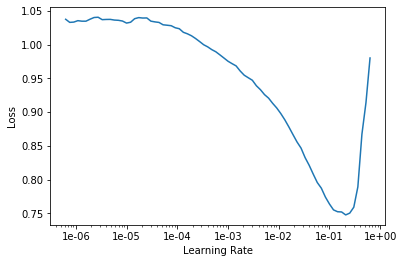

In [21]:
learn_multi.lr_find()
learn_multi.recorder.plot()

In [22]:
learn_multi.fit_one_cycle(3, slice(1e-2))

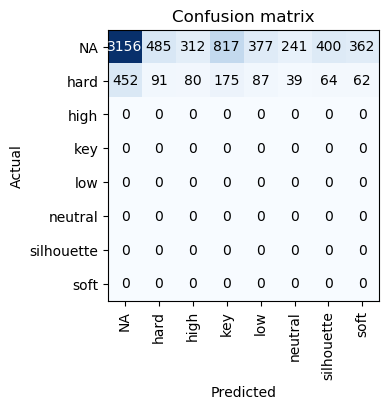

In [23]:
interp = ClassificationInterpretation.from_learner(learn_multi)
interp.plot_confusion_matrix(dpi=100)

In [24]:
learn_single = cnn_learner(data_lighting_single, models.mobilenet_v2,
                           metrics = [accuracy, FBeta()],
                           path = '/home/rahul/tmp/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


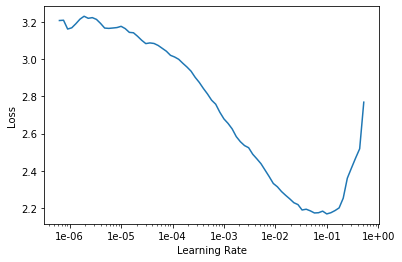

In [25]:
learn_single.lr_find()
learn_single.recorder.plot()

In [26]:
learn_single.fit_one_cycle(4, slice(1e-3))

/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


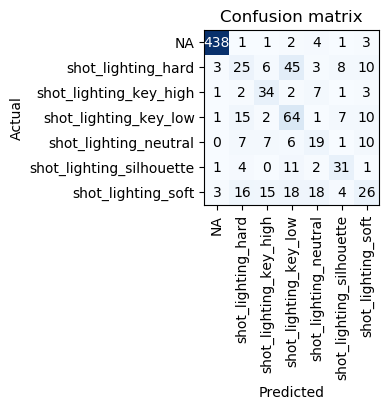

In [27]:
interp = ClassificationInterpretation.from_learner(learn_single)
interp.plot_confusion_matrix(dpi=100)